In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


## Download Tiny_Imagenet dataset

In [2]:
! git clone https://github.com/seshuad/IMagenet
! ls 'IMagenet/tiny-imagenet-200/'

Cloning into 'IMagenet'...
remote: Enumerating objects: 120594, done.
remote: Total 120594 (delta 0), reused 0 (delta 0), pack-reused 120594
Receiving objects: 100% (120594/120594), 212.68 MiB | 31.25 MiB/s, done.
Resolving deltas: 100% (1115/1115), done.
Checking out files: 100% (120206/120206), done.
test  train  val  wnids.txt  words.txt


We'll need to update our path to import from Drive.

In [0]:
import sys
sys.path.append('/content/gdrive/My Drive/EVA4/S12/')


In [0]:
#!unzip tiny-imagenet-200.zip

## PREPERATION OF DATA SET. 


### SPLIT INTO TRAIN AND TEST DATA SETS

In [4]:
import os
from dataset.dataset_utils import create_and_split_dataset, find_classes
import dataset.dataset_utils as data_utils
import importlib
importlib.reload(data_utils)

dir = 'IMagenet/tiny-imagenet-200/train'


classes, class_to_idx = find_classes(dir)
print("Number of classes : ", len(classes))

test_ratio = 30
train_file_names, test_file_names, train_classname_dict, test_classname_dict, classes_dict = create_and_split_dataset(dir, class_to_idx, test_ratio)

Number of classes :  200
Total Image Count =  100000
Train Image Count =  70000
Test  Image Count =  30000


## Find Mean and STD

In [5]:
import torch
from dataset.ImagenetDataset import ImagenetDataset

train_data = ImagenetDataset(dir,train_file_names, train_classname_dict,classes_dict)
test_data = ImagenetDataset(dir,test_file_names,test_classname_dict,classes_dict)


69999
29999


## Now we can import the custom model library and other functions

In [6]:
img, cls =train_data[69999]
print(img.shape,cls)

torch.Size([3, 64, 64]) 199


In [6]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

from albumentations import Compose, RandomCrop, Normalize, HorizontalFlip, Resize
from albumentations.pytorch import ToTensor
from models import Resnet18 as resnet18
from transformations import ImagenetTiny_Alb as imnet

from utils.global_fun import show_summary, run_model_with_entropy,  draw_accuracy_loss_change_graps, plot_accuracy_loss_graphs

import importlib
importlib.reload(resnet18)
importlib.reload(imnet)

use_cuda = torch.cuda.is_available()
#device = torch.device("cuda" if use_cuda else "cpu")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
CUDA_LAUNCH_BLOCKING=1
SEED = 1
# CUDA?
print("CUDA Available?", use_cuda)

# For reproducibility
torch.manual_seed(SEED)

imagenet_num_classes = 200
model = resnet18.ResNet18(imagenet_num_classes).to(device)


if use_cuda:
    torch.cuda.manual_seed(SEED)
   # model = torch.nn.DataParallel(model)





criterion = torch.nn.CrossEntropyLoss()
imagenet_model = imnet.Imagenet_Alb(model,train_data,test_data,criterion,None,None)


show_summary(imagenet_model,input_size=(3,64,64))

cuda
CUDA Available? True
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 64, 64]           1,728
       BatchNorm2d-2           [-1, 64, 64, 64]             128
            Conv2d-3           [-1, 64, 64, 64]          36,864
       BatchNorm2d-4           [-1, 64, 64, 64]             128
            Conv2d-5           [-1, 64, 64, 64]          36,864
       BatchNorm2d-6           [-1, 64, 64, 64]             128
        BasicBlock-7           [-1, 64, 64, 64]               0
            Conv2d-8           [-1, 64, 64, 64]          36,864
       BatchNorm2d-9           [-1, 64, 64, 64]             128
           Conv2d-10           [-1, 64, 64, 64]          36,864
      BatchNorm2d-11           [-1, 64, 64, 64]             128
       BasicBlock-12           [-1, 64, 64, 64]               0
           Conv2d-13          [-1, 128, 32, 32]          73,728
      BatchNo

# Implement custom model with One-Cycle LR

##SHOW PARAMETERS

## **LRFinder** - Range test ( Accuracy v/s LR)

  pip install torch-lr-finder -v --global-option="amp"



Learning rate search finished. See the graph with {finder_name}.plot()
Max Accuracy = 2.0 at LR = 0.2089296130854041


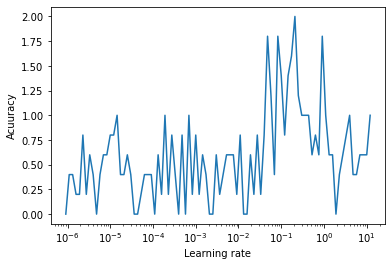

In [7]:

import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
#from torchvision.datasets import CIFAR10
from lr_finder import LRFinder as lrfinder
import dataset.ImagenetDataset as imdataset

#criterion = nn.CrossEntropyLoss()

optimizer = optim.SGD(imagenet_model.m_model.parameters(), lr=1e-7)
lr_finder = lrfinder.LRFinder(imagenet_model.m_model, optimizer, criterion, device="cuda")
lr_finder.range_test(imagenet_model.m_train_loader, end_lr=10, num_iter=100, step_mode="exp")
lr_finder.plot(skip_end=0, accuracy_flag = True)
lr_finder.reset()


# One Cycle LR

In [0]:

from utils.global_fun import test_model
from utils.global_fun import train_model
from utils.global_fun import show_summary, run_model_with_entropy_A11,  draw_accuracy_loss_change_graps, plot_accuracy_loss_graphs

import utils.global_fun as fun
from models import Resnet18 as resnet18
from transformations import ImagenetTiny_Alb as imnet
#import OneCycleLR_A11 as oneCycle 
from CyclicLR import OneCycleLR as oneCycle

#from torch.optim.lr_scheduler import OneCycleLR
criterion = torch.nn.CrossEntropyLoss()
optimizer = optim.SGD(imagenet_model.m_model.parameters(), lr=0.001, momentum=0.9,weight_decay=5e-04)


lr_max = 1.
lr_min = lr_max / 100
epochs     = 15
batch_size = 500
iterations = (epochs*70000)/batch_size

# scheduler = oneCycle.OneCycleLR_A11(optimizer, batch_size, 30, (lr_min, lr_max), (0.85, 0.95))
scheduler = oneCycle.OneCycleLR(optimizer, iterations, lr_range = (lr_min, lr_max), momentum_range =(0.85, 0.95), annihilation_frac = 0.2, reduce_factor =0.01)

imagenet_model.setOptimizer(optimizer)
imagenet_model.setScheduler(scheduler)


RUNNING WITH REGULARIZATION

In [9]:

run_model_with_entropy_A11(imagenet_model, device, doL1= 0, doL2=0, LAMBDA=0, EPOCHS=epochs)

  0%|          | 0/140 [00:00<?, ?it/s]

EPOCH: 0

OneCyclicLR:  steps: 0/2100.0, LR: 0.0100, Momentum: 0.9500%

L1= 0 ;L2= 0 ;LAMBDA= 0 epoch= 0


Loss=4.338151931762695 Batch_id=139 Accuracy=5.03: 100%|██████████| 140/140 [04:31<00:00,  1.94s/it]
  0%|          | 0/140 [00:00<?, ?it/s]


Test set: Average loss: 0.0103, Accuracy: 1320/30000 (4.40%)

EPOCH: 1

OneCyclicLR:  steps: 140/2100.0, LR: 0.1750, Momentum: 0.9333%

L1= 0 ;L2= 0 ;LAMBDA= 0 epoch= 1


Loss=3.9796388149261475 Batch_id=139 Accuracy=11.86: 100%|██████████| 140/140 [04:31<00:00,  1.94s/it]
  0%|          | 0/140 [00:00<?, ?it/s]


Test set: Average loss: 0.0098, Accuracy: 2323/30000 (7.74%)

EPOCH: 2

OneCyclicLR:  steps: 280/2100.0, LR: 0.3400, Momentum: 0.9167%

L1= 0 ;L2= 0 ;LAMBDA= 0 epoch= 2


Loss=3.5155246257781982 Batch_id=139 Accuracy=18.28: 100%|██████████| 140/140 [04:31<00:00,  1.94s/it]
  0%|          | 0/140 [00:00<?, ?it/s]


Test set: Average loss: 0.0080, Accuracy: 3973/30000 (13.24%)

EPOCH: 3

OneCyclicLR:  steps: 420/2100.0, LR: 0.5050, Momentum: 0.9000%

L1= 0 ;L2= 0 ;LAMBDA= 0 epoch= 3


Loss=3.239475727081299 Batch_id=139 Accuracy=23.06: 100%|██████████| 140/140 [04:31<00:00,  1.94s/it]
  0%|          | 0/140 [00:00<?, ?it/s]


Test set: Average loss: 0.0086, Accuracy: 3348/30000 (11.16%)

EPOCH: 4

OneCyclicLR:  steps: 560/2100.0, LR: 0.6700, Momentum: 0.8833%

L1= 0 ;L2= 0 ;LAMBDA= 0 epoch= 4


Loss=3.0238802433013916 Batch_id=139 Accuracy=26.95: 100%|██████████| 140/140 [04:31<00:00,  1.94s/it]
  0%|          | 0/140 [00:00<?, ?it/s]


Test set: Average loss: 0.0074, Accuracy: 5933/30000 (19.78%)

EPOCH: 5

OneCyclicLR:  steps: 700/2100.0, LR: 0.8350, Momentum: 0.8667%

L1= 0 ;L2= 0 ;LAMBDA= 0 epoch= 5


Loss=2.9203526973724365 Batch_id=139 Accuracy=29.81: 100%|██████████| 140/140 [04:31<00:00,  1.94s/it]
  0%|          | 0/140 [00:00<?, ?it/s]


Test set: Average loss: 0.0083, Accuracy: 4399/30000 (14.66%)

EPOCH: 6

OneCyclicLR:  steps: 840/2100.0, LR: 1.0000, Momentum: 0.8500%

L1= 0 ;L2= 0 ;LAMBDA= 0 epoch= 6


Loss=2.8577253818511963 Batch_id=139 Accuracy=33.25: 100%|██████████| 140/140 [04:30<00:00,  1.94s/it]
  0%|          | 0/140 [00:00<?, ?it/s]


Test set: Average loss: 0.0074, Accuracy: 6287/30000 (20.96%)

EPOCH: 7

OneCyclicLR:  steps: 980/2100.0, LR: 0.8350, Momentum: 0.8667%

L1= 0 ;L2= 0 ;LAMBDA= 0 epoch= 7


Loss=2.6167116165161133 Batch_id=139 Accuracy=36.52: 100%|██████████| 140/140 [04:30<00:00,  1.93s/it]
  0%|          | 0/140 [00:00<?, ?it/s]


Test set: Average loss: 0.0069, Accuracy: 6737/30000 (22.46%)

EPOCH: 8

OneCyclicLR:  steps: 1120/2100.0, LR: 0.6700, Momentum: 0.8833%

L1= 0 ;L2= 0 ;LAMBDA= 0 epoch= 8


Loss=2.405613660812378 Batch_id=139 Accuracy=40.67: 100%|██████████| 140/140 [04:30<00:00,  1.93s/it]
  0%|          | 0/140 [00:00<?, ?it/s]


Test set: Average loss: 0.0065, Accuracy: 7982/30000 (26.61%)

EPOCH: 9

OneCyclicLR:  steps: 1260/2100.0, LR: 0.5050, Momentum: 0.9000%

L1= 0 ;L2= 0 ;LAMBDA= 0 epoch= 9


Loss=2.220290184020996 Batch_id=139 Accuracy=44.72: 100%|██████████| 140/140 [04:30<00:00,  1.93s/it]
  0%|          | 0/140 [00:00<?, ?it/s]


Test set: Average loss: 0.0059, Accuracy: 9964/30000 (33.21%)

EPOCH: 10

OneCyclicLR:  steps: 1400/2100.0, LR: 0.3400, Momentum: 0.9167%

L1= 0 ;L2= 0 ;LAMBDA= 0 epoch= 10


Loss=1.8407186269760132 Batch_id=139 Accuracy=50.84: 100%|██████████| 140/140 [04:30<00:00,  1.93s/it]
  0%|          | 0/140 [00:00<?, ?it/s]


Test set: Average loss: 0.0052, Accuracy: 11614/30000 (38.71%)

EPOCH: 11

OneCyclicLR:  steps: 1540/2100.0, LR: 0.1750, Momentum: 0.9333%

L1= 0 ;L2= 0 ;LAMBDA= 0 epoch= 11


Loss=1.2165296077728271 Batch_id=139 Accuracy=63.74: 100%|██████████| 140/140 [04:30<00:00,  1.93s/it]
  0%|          | 0/140 [00:00<?, ?it/s]


Test set: Average loss: 0.0040, Accuracy: 15377/30000 (51.26%)

EPOCH: 12

OneCyclicLR:  steps: 1680/2100.0, LR: 0.0100, Momentum: 0.9500%

L1= 0 ;L2= 0 ;LAMBDA= 0 epoch= 12


Loss=0.7655404806137085 Batch_id=139 Accuracy=80.61: 100%|██████████| 140/140 [04:30<00:00,  1.93s/it]
  0%|          | 0/140 [00:00<?, ?it/s]


Test set: Average loss: 0.0039, Accuracy: 15882/30000 (52.94%)

EPOCH: 13

OneCyclicLR:  steps: 1820/2100.0, LR: 0.0067, Momentum: 0.9500%

L1= 0 ;L2= 0 ;LAMBDA= 0 epoch= 13


Loss=0.6721519231796265 Batch_id=139 Accuracy=84.51: 100%|██████████| 140/140 [04:30<00:00,  1.93s/it]
  0%|          | 0/140 [00:00<?, ?it/s]


Test set: Average loss: 0.0039, Accuracy: 15851/30000 (52.84%)

EPOCH: 14

OneCyclicLR:  steps: 1960/2100.0, LR: 0.0034, Momentum: 0.9500%

L1= 0 ;L2= 0 ;LAMBDA= 0 epoch= 14


Loss=0.6365746259689331 Batch_id=139 Accuracy=86.73: 100%|██████████| 140/140 [04:30<00:00,  1.93s/it]



Test set: Average loss: 0.0039, Accuracy: 15797/30000 (52.66%)



In [12]:
def ClassTestAccuracy(testloader,device,model):
  class_correct = list(0. for i in range(200))
  class_total = list(0. for i in range(200))
  with torch.no_grad():
      for data in testloader:
          images, labels = data
          images =images.to(device)
          labels = labels.to(device)
          outputs = model(images)
          _, predicted = torch.max(outputs, 1)
          c = (predicted == labels).squeeze()
          for i in range(len(labels)):
              label = labels[i]
              class_correct[label] += c[i].item()
              class_total[label] += 1

  for i in range(200):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))
    
ClassTestAccuracy(imagenet_model.m_test_loader, device, imagenet_model.m_model)

Accuracy of n01443537 : 70 %
Accuracy of n01629819 : 80 %
Accuracy of n01641577 : 54 %
Accuracy of n01644900 : 39 %
Accuracy of n01698640 : 55 %
Accuracy of n01742172 : 50 %
Accuracy of n01768244 : 68 %
Accuracy of n01770393 : 39 %
Accuracy of n01774384 : 65 %
Accuracy of n01774750 : 50 %
Accuracy of n01784675 : 37 %
Accuracy of n01855672 : 55 %
Accuracy of n01882714 : 64 %
Accuracy of n01910747 : 68 %
Accuracy of n01917289 : 66 %
Accuracy of n01944390 : 45 %
Accuracy of n01945685 : 34 %
Accuracy of n01950731 : 63 %
Accuracy of n01983481 : 52 %
Accuracy of n01984695 : 55 %
Accuracy of n02002724 : 62 %
Accuracy of n02056570 : 65 %
Accuracy of n02058221 : 67 %
Accuracy of n02074367 : 80 %
Accuracy of n02085620 : 38 %
Accuracy of n02094433 : 56 %
Accuracy of n02099601 : 52 %
Accuracy of n02099712 : 32 %
Accuracy of n02106662 : 55 %
Accuracy of n02113799 : 40 %
Accuracy of n02123045 : 44 %
Accuracy of n02123394 : 59 %
Accuracy of n02124075 : 42 %
Accuracy of n02125311 : 53 %
Accuracy of n0

incorrect samples collected for gradcam= 30
####################################################################
torch.Size([3, 64, 64])
Predicted value =  n04376876
activation Size :  (32, 32, 128)


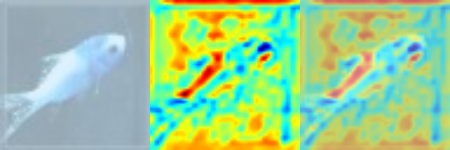

     ACTUAL          GRADCAM           Gradcam+Image
Actual Value    =  n01443537
activation Size :  (32, 32, 128)


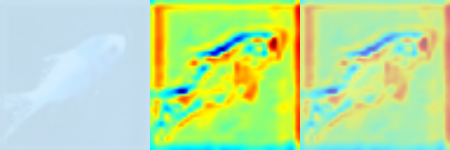

     ACTUAL          GRADCAM           Gradcam+Image
####################################################################
####################################################################
torch.Size([3, 64, 64])
Predicted value =  n01950731
activation Size :  (32, 32, 128)


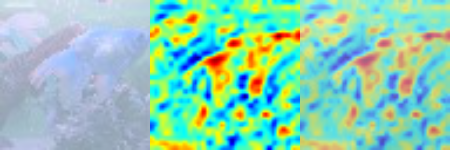

     ACTUAL          GRADCAM           Gradcam+Image
Actual Value    =  n01443537
activation Size :  (32, 32, 128)


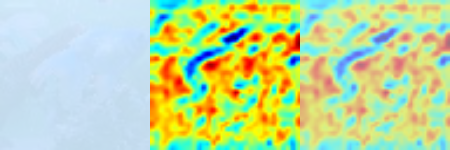

     ACTUAL          GRADCAM           Gradcam+Image
####################################################################
####################################################################
torch.Size([3, 64, 64])
Predicted value =  n07734744
activation Size :  (32, 32, 128)


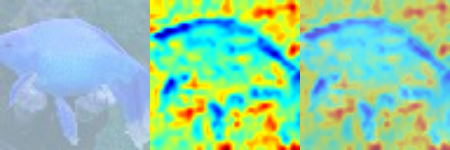

     ACTUAL          GRADCAM           Gradcam+Image
Actual Value    =  n01443537
activation Size :  (32, 32, 128)


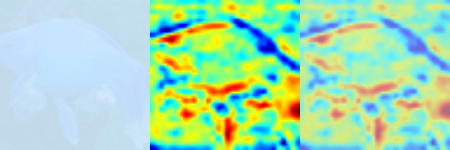

     ACTUAL          GRADCAM           Gradcam+Image
####################################################################
####################################################################
torch.Size([3, 64, 64])
Predicted value =  n01910747
activation Size :  (32, 32, 128)


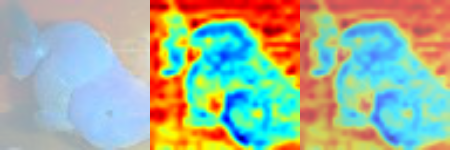

     ACTUAL          GRADCAM           Gradcam+Image
Actual Value    =  n01443537
activation Size :  (32, 32, 128)


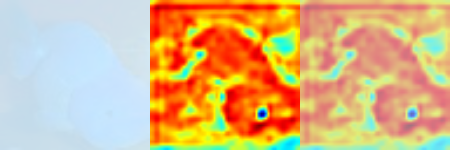

     ACTUAL          GRADCAM           Gradcam+Image
####################################################################
####################################################################
torch.Size([3, 64, 64])
Predicted value =  n04398044
activation Size :  (32, 32, 128)


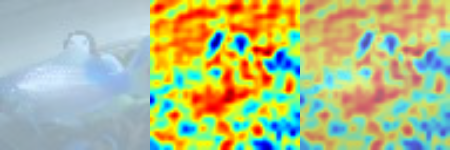

     ACTUAL          GRADCAM           Gradcam+Image
Actual Value    =  n01443537
activation Size :  (32, 32, 128)


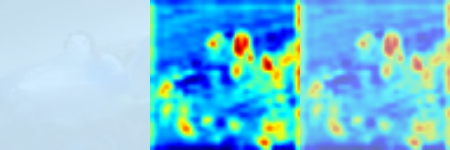

     ACTUAL          GRADCAM           Gradcam+Image
####################################################################
####################################################################
torch.Size([3, 64, 64])
Predicted value =  n07768694
activation Size :  (32, 32, 128)


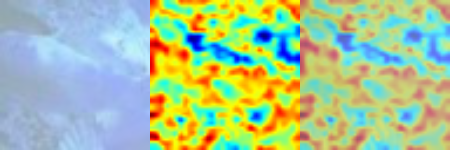

     ACTUAL          GRADCAM           Gradcam+Image
Actual Value    =  n01443537
activation Size :  (32, 32, 128)


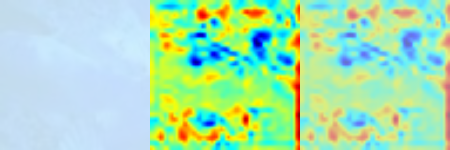

     ACTUAL          GRADCAM           Gradcam+Image
####################################################################
####################################################################
torch.Size([3, 64, 64])
Predicted value =  n07615774
activation Size :  (32, 32, 128)


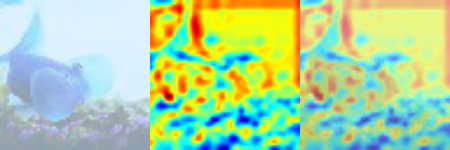

     ACTUAL          GRADCAM           Gradcam+Image
Actual Value    =  n01443537
activation Size :  (32, 32, 128)


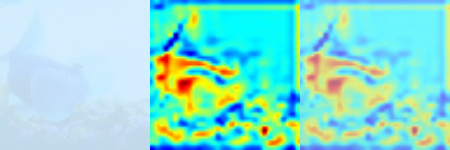

     ACTUAL          GRADCAM           Gradcam+Image
####################################################################
####################################################################
torch.Size([3, 64, 64])
Predicted value =  n02099601
activation Size :  (32, 32, 128)


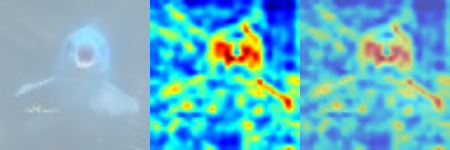

     ACTUAL          GRADCAM           Gradcam+Image
Actual Value    =  n01443537
activation Size :  (32, 32, 128)


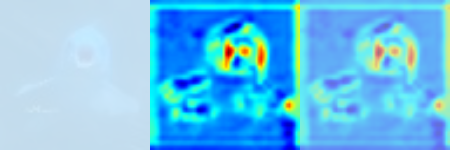

     ACTUAL          GRADCAM           Gradcam+Image
####################################################################
####################################################################
torch.Size([3, 64, 64])
Predicted value =  n04275548
activation Size :  (32, 32, 128)


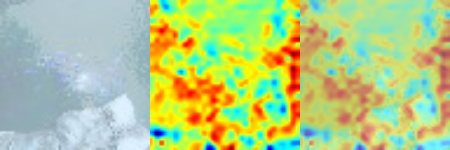

     ACTUAL          GRADCAM           Gradcam+Image
Actual Value    =  n01443537
activation Size :  (32, 32, 128)


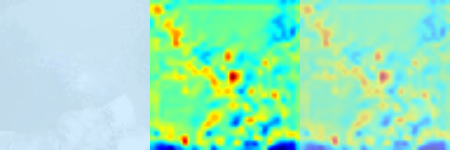

     ACTUAL          GRADCAM           Gradcam+Image
####################################################################
####################################################################
torch.Size([3, 64, 64])
Predicted value =  n03042490
activation Size :  (32, 32, 128)


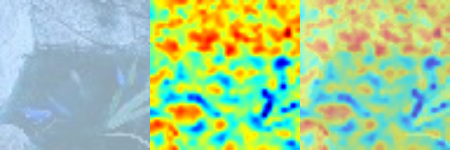

     ACTUAL          GRADCAM           Gradcam+Image
Actual Value    =  n01443537
activation Size :  (32, 32, 128)


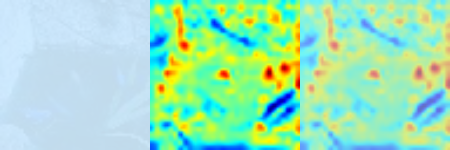

     ACTUAL          GRADCAM           Gradcam+Image
####################################################################
####################################################################
torch.Size([3, 64, 64])
Predicted value =  n03804744
activation Size :  (32, 32, 128)


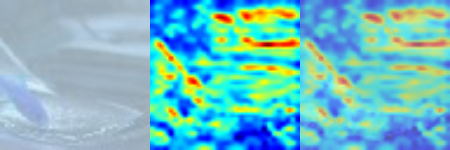

     ACTUAL          GRADCAM           Gradcam+Image
Actual Value    =  n01443537
activation Size :  (32, 32, 128)


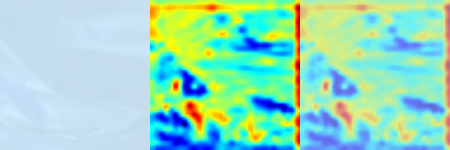

     ACTUAL          GRADCAM           Gradcam+Image
####################################################################
####################################################################
torch.Size([3, 64, 64])
Predicted value =  n04399382
activation Size :  (32, 32, 128)


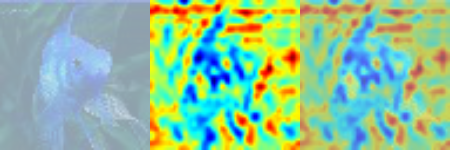

     ACTUAL          GRADCAM           Gradcam+Image
Actual Value    =  n01443537
activation Size :  (32, 32, 128)


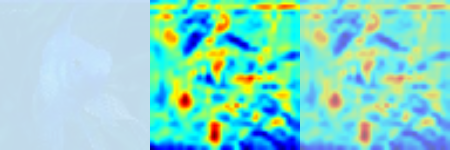

     ACTUAL          GRADCAM           Gradcam+Image
####################################################################
####################################################################
torch.Size([3, 64, 64])
Predicted value =  n01950731
activation Size :  (32, 32, 128)


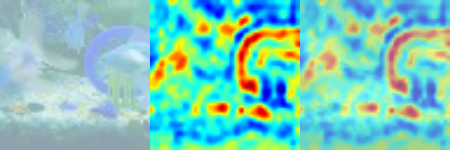

     ACTUAL          GRADCAM           Gradcam+Image
Actual Value    =  n01443537
activation Size :  (32, 32, 128)


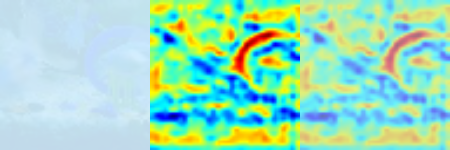

     ACTUAL          GRADCAM           Gradcam+Image
####################################################################
####################################################################
torch.Size([3, 64, 64])
Predicted value =  n01944390
activation Size :  (32, 32, 128)


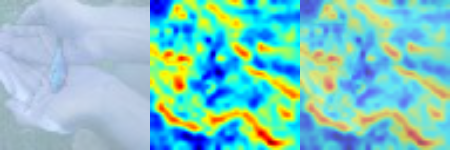

     ACTUAL          GRADCAM           Gradcam+Image
Actual Value    =  n01443537
activation Size :  (32, 32, 128)


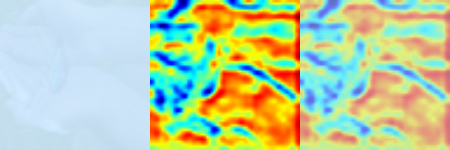

     ACTUAL          GRADCAM           Gradcam+Image
####################################################################
####################################################################
torch.Size([3, 64, 64])
Predicted value =  n01950731
activation Size :  (32, 32, 128)


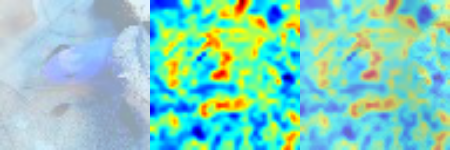

     ACTUAL          GRADCAM           Gradcam+Image
Actual Value    =  n01443537
activation Size :  (32, 32, 128)


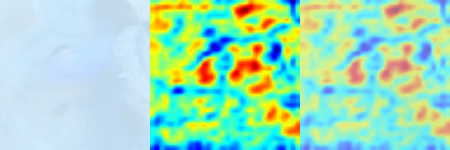

     ACTUAL          GRADCAM           Gradcam+Image
####################################################################
####################################################################
torch.Size([3, 64, 64])
Predicted value =  n04067472
activation Size :  (32, 32, 128)


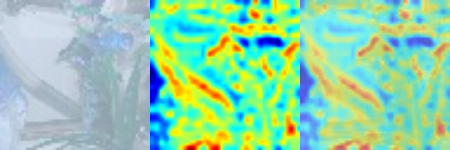

     ACTUAL          GRADCAM           Gradcam+Image
Actual Value    =  n01443537
activation Size :  (32, 32, 128)


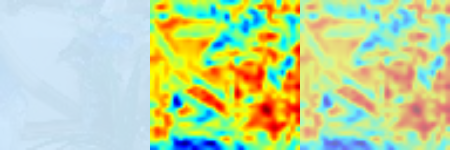

     ACTUAL          GRADCAM           Gradcam+Image
####################################################################
####################################################################
torch.Size([3, 64, 64])
Predicted value =  n07720875
activation Size :  (32, 32, 128)


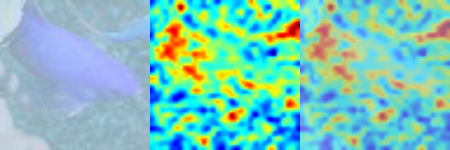

     ACTUAL          GRADCAM           Gradcam+Image
Actual Value    =  n01443537
activation Size :  (32, 32, 128)


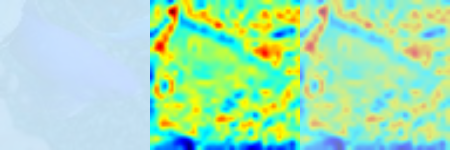

     ACTUAL          GRADCAM           Gradcam+Image
####################################################################
####################################################################
torch.Size([3, 64, 64])
Predicted value =  n02364673
activation Size :  (32, 32, 128)


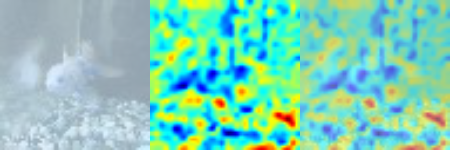

     ACTUAL          GRADCAM           Gradcam+Image
Actual Value    =  n01443537
activation Size :  (32, 32, 128)


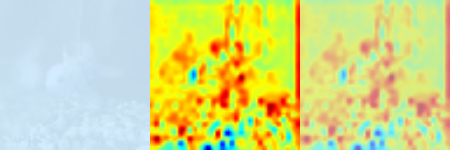

     ACTUAL          GRADCAM           Gradcam+Image
####################################################################
####################################################################
torch.Size([3, 64, 64])
Predicted value =  n03937543
activation Size :  (32, 32, 128)


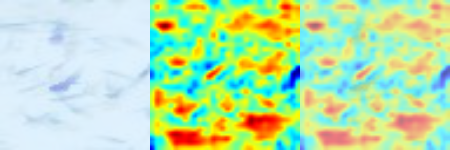

     ACTUAL          GRADCAM           Gradcam+Image
Actual Value    =  n01443537
activation Size :  (32, 32, 128)


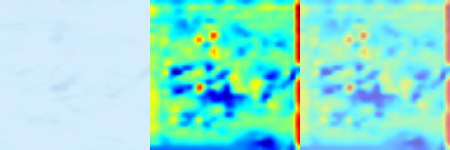

     ACTUAL          GRADCAM           Gradcam+Image
####################################################################
####################################################################
torch.Size([3, 64, 64])
Predicted value =  n07749582
activation Size :  (32, 32, 128)


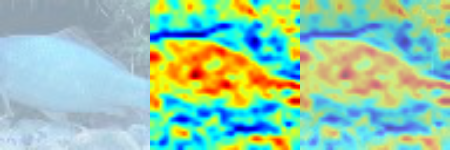

     ACTUAL          GRADCAM           Gradcam+Image
Actual Value    =  n01443537
activation Size :  (32, 32, 128)


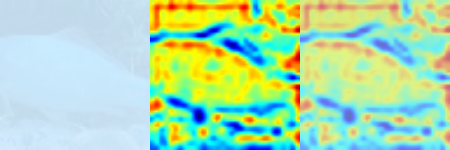

     ACTUAL          GRADCAM           Gradcam+Image
####################################################################
####################################################################
torch.Size([3, 64, 64])
Predicted value =  n01950731
activation Size :  (32, 32, 128)


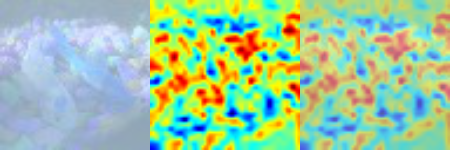

     ACTUAL          GRADCAM           Gradcam+Image
Actual Value    =  n01443537
activation Size :  (32, 32, 128)


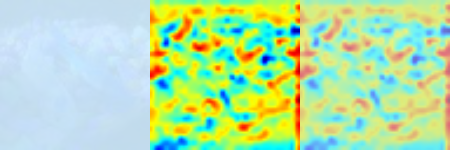

     ACTUAL          GRADCAM           Gradcam+Image
####################################################################
####################################################################
torch.Size([3, 64, 64])
Predicted value =  n12267677
activation Size :  (32, 32, 128)


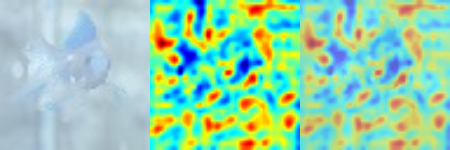

     ACTUAL          GRADCAM           Gradcam+Image
Actual Value    =  n01443537
activation Size :  (32, 32, 128)


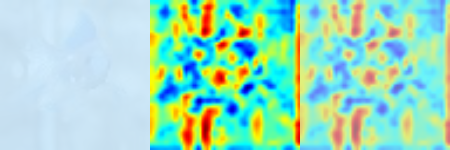

     ACTUAL          GRADCAM           Gradcam+Image
####################################################################
####################################################################
torch.Size([3, 64, 64])
Predicted value =  n04596742
activation Size :  (32, 32, 128)


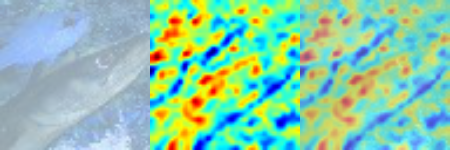

     ACTUAL          GRADCAM           Gradcam+Image
Actual Value    =  n01443537
activation Size :  (32, 32, 128)


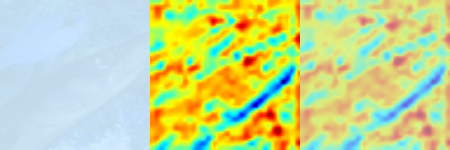

     ACTUAL          GRADCAM           Gradcam+Image
####################################################################
####################################################################
torch.Size([3, 64, 64])
Predicted value =  n09256479
activation Size :  (32, 32, 128)


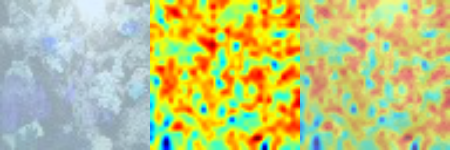

     ACTUAL          GRADCAM           Gradcam+Image
Actual Value    =  n01443537
activation Size :  (32, 32, 128)


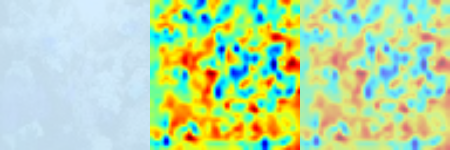

     ACTUAL          GRADCAM           Gradcam+Image
####################################################################
####################################################################
torch.Size([3, 64, 64])
Predicted value =  n02165456
activation Size :  (32, 32, 128)


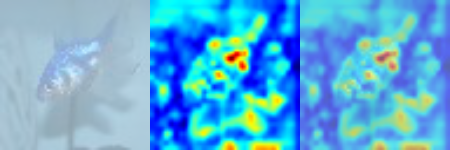

     ACTUAL          GRADCAM           Gradcam+Image
Actual Value    =  n01443537
activation Size :  (32, 32, 128)


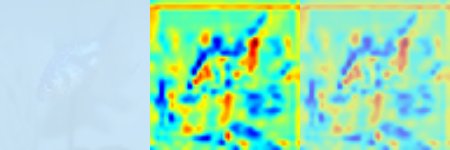

     ACTUAL          GRADCAM           Gradcam+Image
####################################################################
####################################################################
torch.Size([3, 64, 64])
Predicted value =  n02948072
activation Size :  (32, 32, 128)


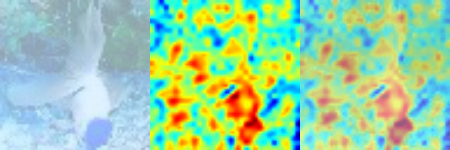

     ACTUAL          GRADCAM           Gradcam+Image
Actual Value    =  n01443537
activation Size :  (32, 32, 128)


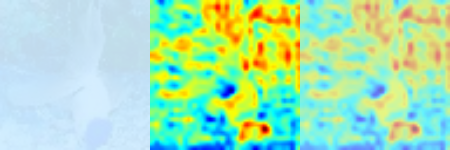

     ACTUAL          GRADCAM           Gradcam+Image
####################################################################
####################################################################
torch.Size([3, 64, 64])
Predicted value =  n02165456
activation Size :  (32, 32, 128)


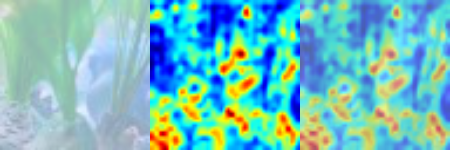

     ACTUAL          GRADCAM           Gradcam+Image
Actual Value    =  n01443537
activation Size :  (32, 32, 128)


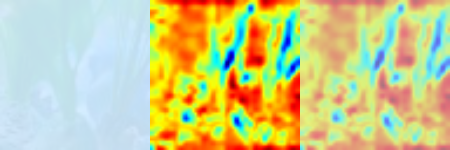

     ACTUAL          GRADCAM           Gradcam+Image
####################################################################
####################################################################
torch.Size([3, 64, 64])
Predicted value =  n07720875
activation Size :  (32, 32, 128)


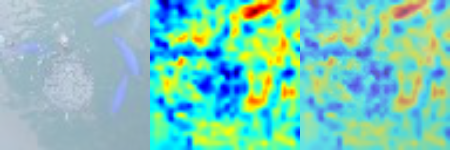

     ACTUAL          GRADCAM           Gradcam+Image
Actual Value    =  n01443537
activation Size :  (32, 32, 128)


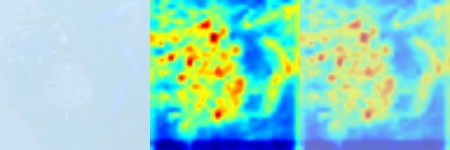

     ACTUAL          GRADCAM           Gradcam+Image
####################################################################
####################################################################
torch.Size([3, 64, 64])
Predicted value =  n02123394
activation Size :  (32, 32, 128)


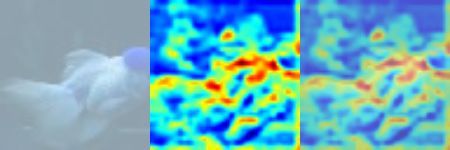

     ACTUAL          GRADCAM           Gradcam+Image
Actual Value    =  n01443537
activation Size :  (32, 32, 128)


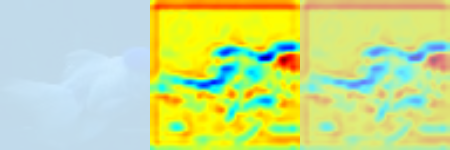

     ACTUAL          GRADCAM           Gradcam+Image
####################################################################
####################################################################
torch.Size([3, 64, 64])
Predicted value =  n09246464
activation Size :  (32, 32, 128)


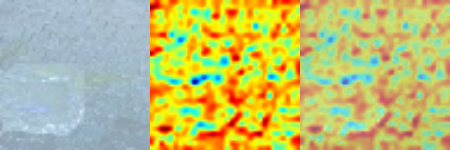

     ACTUAL          GRADCAM           Gradcam+Image
Actual Value    =  n01443537
activation Size :  (32, 32, 128)


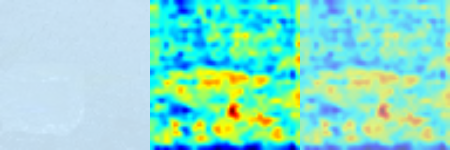

     ACTUAL          GRADCAM           Gradcam+Image
####################################################################


In [15]:
import random
import torch
from torch import nn
import torch.nn as nn
from torch.nn import functional as F
from torchvision.utils import save_image
from torchvision.models import densenet121, resnet18, resnet152, resnet101
from torchvision.transforms import functional as tf
import os
import numpy as np
import matplotlib.pyplot as plt

from PIL import Image
from GradCAM import GradCAM

model = imagenet_model.m_model.to('cpu')
gradcam_object = GradCAM.GradCAM(model, model.layer2, classes)


print('incorrect samples collected for gradcam=',len(imagenet_model.m_incorrect_samples))
if(len(imagenet_model.m_incorrect_samples) > 1):
  images = [x for x in random.sample(imagenet_model.m_incorrect_samples, 30)]
  for img in images:
    print("####################################################################")
    print(img['image'].size())
    im_      = img['image'].reshape(1,3,64,64).clone().detach()
    prediction = img["prediction"].item()
    label      = img["label"].item()
    print("Predicted value = ", classes[prediction])
    cam, heatmap, pred = gradcam_object.forward(im_, prediction, retain_graph= True)
    gradcam_object.visualiseGradcam(heatmap, im_)

    print("Actual Value    = ",classes[label])
    cam, heatmap, pred = gradcam_object.forward(im_, label, retain_graph= True)
    gradcam_object.visualiseGradcam(heatmap, im_)

    print("####################################################################")
  